In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip


--2024-08-06 06:35:58--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  20.4MB/s    in 4.1s    

2024-08-06 06:36:02 (16.1 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

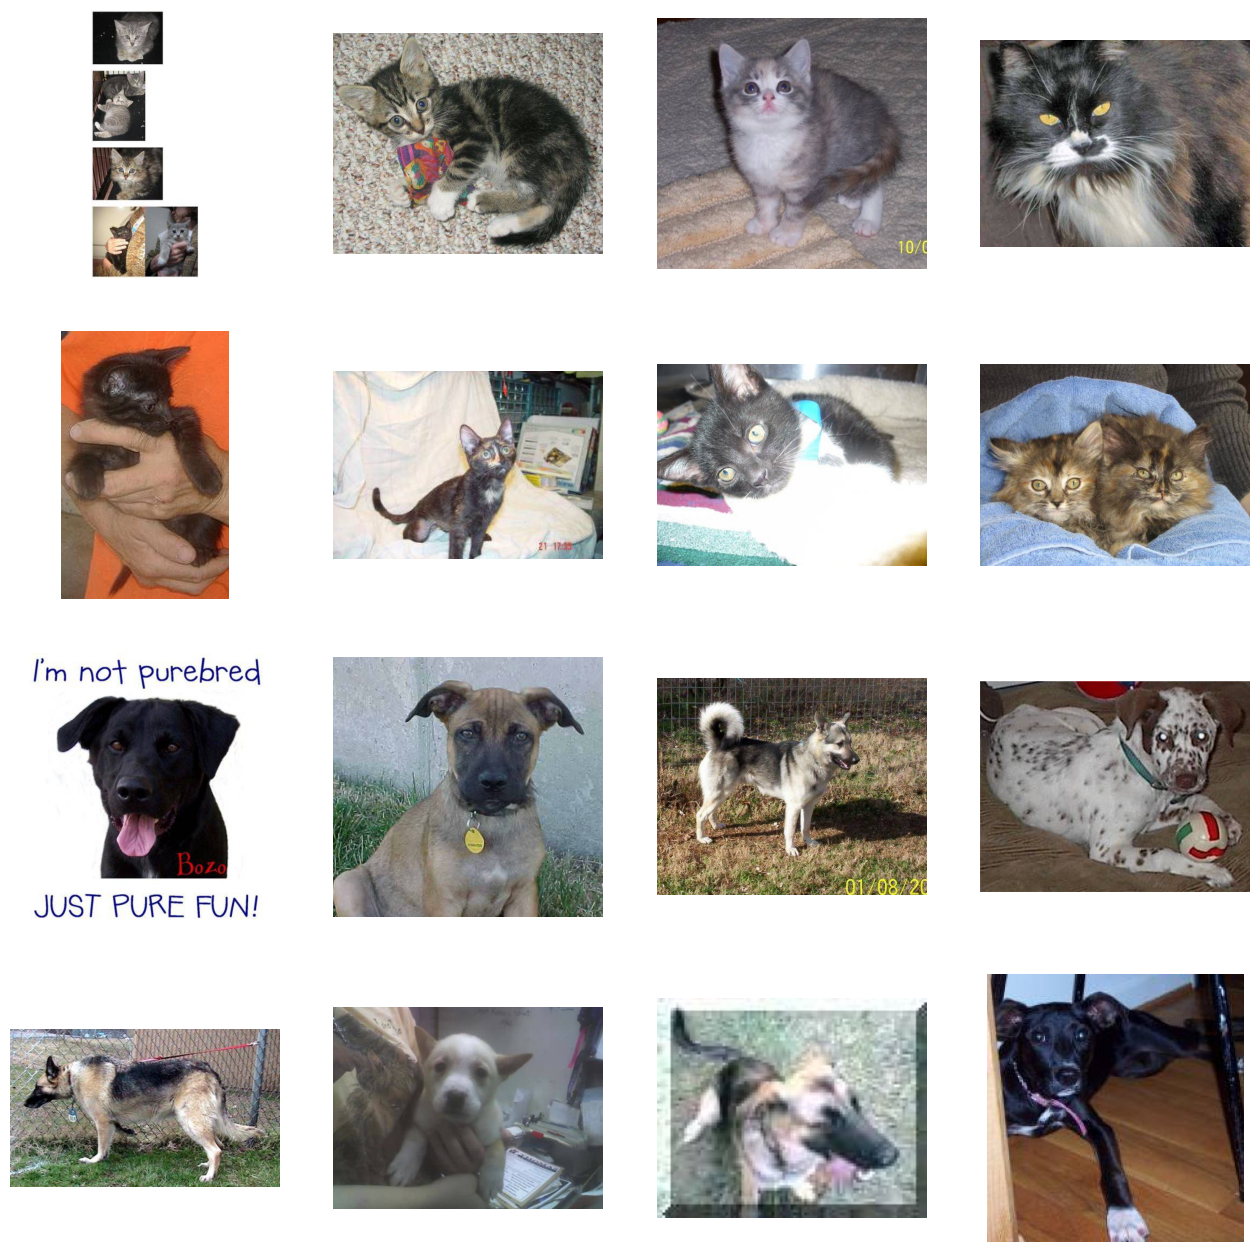

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255.)#,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = True, # Leave out the last fully connected layer
weights = 'imagenet')
base_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 154ms/step - acc: 0.6809 - loss: 0.7950 - val_acc: 0.8730 - val_loss: 0.2921
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8730 - val_loss: 0.2921
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - acc: 0.8797 - loss: 0.2632 - val_acc: 0.8710 - val_loss: 0.3092
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8710 - val_loss: 0.3092
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 153ms/step - acc: 0.8950 - loss: 0.2362 - val_acc: 0.8690 - val_loss: 0.3127
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.8690 - val_loss: 0.3127
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - acc: 0.9257 - loss: 0.1717 - val_acc: 0.9070 - val_loss: 0.2273
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.9070 - val_loss: 0.2273
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - acc: 0.9396 - loss: 0.1325 - val_acc: 0.9050 - val_loss: 0.2319
Epoch 10/10
100/100

In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

['input_layer',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten',
 'dense',
 'dropout',
 'dense_1']

In [ ]:
layer_outputs = [layer.output for layer in model.layers]
print(len(layer_outputs))


23


In [ ]:
feature_map_model = tf.keras.models.Model(model.input, layer_outputs[17])

Found 1000 images belonging to 2 classes.


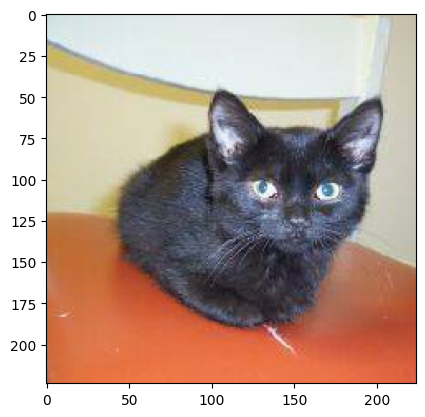

In [ ]:
test_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 1, class_mode = None, target_size = (224, 224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
myImage = test_generator[0]
plt.imshow(myImage[0])
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
(1, 14, 14, 512)


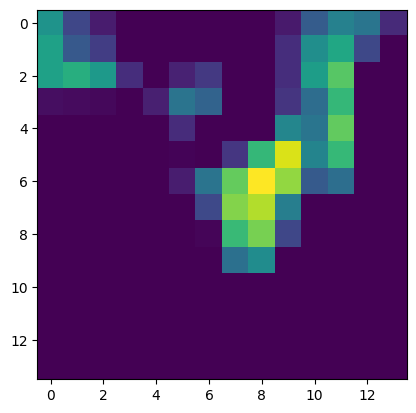

In [ ]:
feature_map_model = tf.keras.models.Model(model.input, layer_outputs[17])
feature_maps = feature_map_model.predict(myImage,verbose=1)
print(feature_maps.shape)
plt.imshow(feature_maps[0,:,:,50])
plt.show()

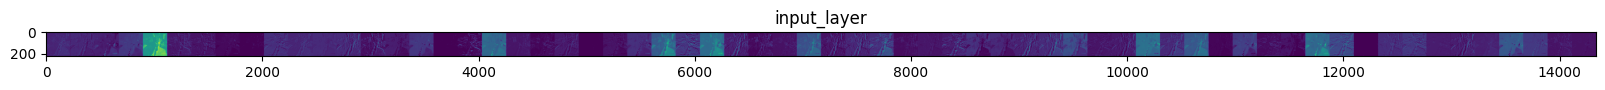

In [ ]:
import numpy as np
k = feature_maps.shape[-1]
size= feature_maps.shape[1]
scale = 20. / k
image_belt = np.zeros((size, size * k))
for i in range(k):
  feature_image = feature_maps[0, :, :, i]
  image_belt[:, i * size : (i + 1) * size] = feature_image

plt.figure( figsize=(scale * k, scale) )
plt.title ( layer_name )
plt.grid  ( False )
plt.imshow(image_belt , aspect='auto')